In [1]:
# Execute essa célula se é a primeira vez que você usa esse notebook
# pip install opencv-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

import matplotlib.image as mpimg
import networkx as nx

import cv2

In [3]:
# Connect to the Coppeliasim API
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(False)


0

In [4]:
def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

In [5]:
goal_handle = sim.getObject('/ReferenceFrame')

# Informações do robô
# Robotino
robot_path = '/robotino'
robot_handle = sim.getObject(robot_path)
wheel = [sim.getObject(robot_path + f'/wheel{i}_joint') for i in range(3)]

# Específico do robô
L = 0.135
r = 0.040

**Escolha a cena a ser usada abaixo:**

In [6]:
scenes = {
    'cave': {
        'img': 'img/cave.png',
        'dilation': 5,
        'dims': (20, 20),
        'cell size': 0.5,
    },
    'square maze': {
        'img': 'img/square_maze.png',
        'dilation': 3,
        'dims': (50, 50),
        'cell size': 0.8,
    },
    'walls': {
        'img': 'img/walls.png',
        'dilation': 1,
        'dims': (13, 13),
        'cell size': 0.25,
    },
}

# scene = 'cave'
scene = 'square maze'
# scene = 'walls'

## Roadmaps
Implementação de roadmaps para **robô holonômico**.

(759, 759)

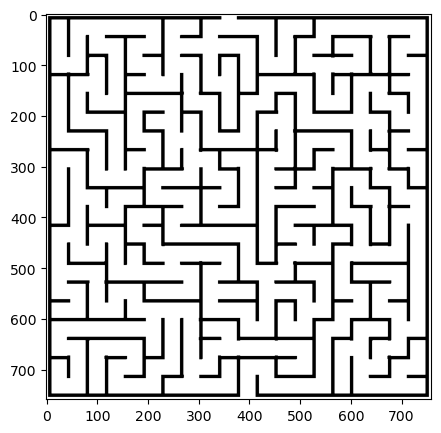

In [7]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

source_img = mpimg.imread(scenes[scene]['img'])
source_img = source_img.copy()

threshold = 0.5
source_img[source_img >= threshold] = 1
source_img[source_img < threshold] = 0

ax.imshow(source_img, cmap='Greys', origin='upper')
source_img.shape

Ao escolher o caminho o qual o robô irá percorrer, corremos o risco de não considerarmos o diâmetro do robô. Para resolver esse problema, **dilatamos os obstáculos** do mapa original. Assim, garantimos que o caminho escolhido não fará o robô se chocar com obstáculos.

(759, 759)

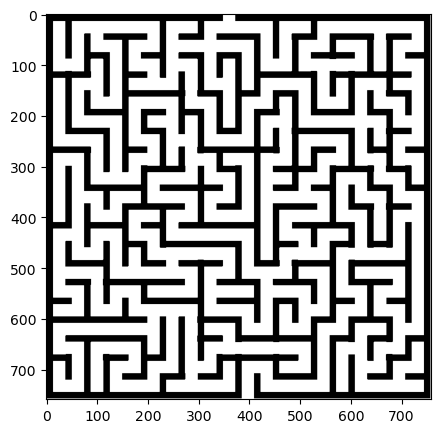

In [8]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Tamanho da dilatação.
dilation_size = scenes[scene]['dilation']

# Dilata os obstáculos
img_uint8 = (source_img * 255).astype(np.uint8)
selem = cv2.getStructuringElement(cv2.MORPH_RECT, (2*dilation_size + 1, 2*dilation_size + 1))
img= cv2.dilate(img_uint8, selem)

# Converte a imagem para o formato original
img = img.astype(np.float32) / 255

ax.imshow(img, cmap='Greys', origin='upper')
img.shape # Perceba que o tamanho da imagem continua o mesmo

Com o mapa, criamos o grafo de posições livres, ou seja, posições que o robô pode ocupar sem se chocar com um obstáculo.

In [9]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array(scenes[scene]['dims'])
cell_size = scenes[scene]['cell size']

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid >= threshold] = 1
grid[grid < threshold] = 0     

# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))

# Adicionando arestas diagonais
for node in G.nodes():
    r, c = node
    diagonal_neighbors = [(r-1, c-1), (r-1, c+1), (r+1, c-1), (r+1, c+1)]
    # Adicionamos uma aresta diagonal somente se o vizinho entre as células é livre
    for neighbor in diagonal_neighbors:
        if not neighbor in G.nodes():
            continue
        if (r, neighbor[1]) in G.nodes() and (neighbor[0], c) in G.nodes():   
            G.add_edge(node, neighbor)

pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}

Note que no grafo **G**, o eixo x é representado pelo **segundo elemento** do nó. Ou seja, se cada nó possui a forma (i, j), essas coordenadas correspondem às coordenadas (y, x) na cena.

In [10]:
x_dim = map_dims[0] / 2
y_dim = map_dims[1] / 2

# Transformação das coordenadas na cena para as coordenadas no grafo
arr_x = lambda x: int((x_dim + x) / cell_size)
arr_y = lambda y: int((-y + y_dim) / cell_size)

# Transformação das coordenadas no grafo para as coordenadas na cena
scene_x = lambda x: (x * cell_size) - x_dim
scene_y = lambda y: y_dim - (y * cell_size)

In [11]:
def plot_graph_position(node):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    
    # Grid
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)
    
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))
    
    # Os vértices serão plotados no centro da célula  
    pos = {node: (node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2)}
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=50, node_color="g", ax=ax)

Obtemos a posição do robô e do alvo na cena e com isso calculamos a posição dos mesmos no grafo.

Nos gráficos abaixo, o ponto verde representa a posição do objeto na cena, e as células em vermelhos são células ocupadas por obstáculos, enquanto as áreas em preto são os obstáculos efetivamente.


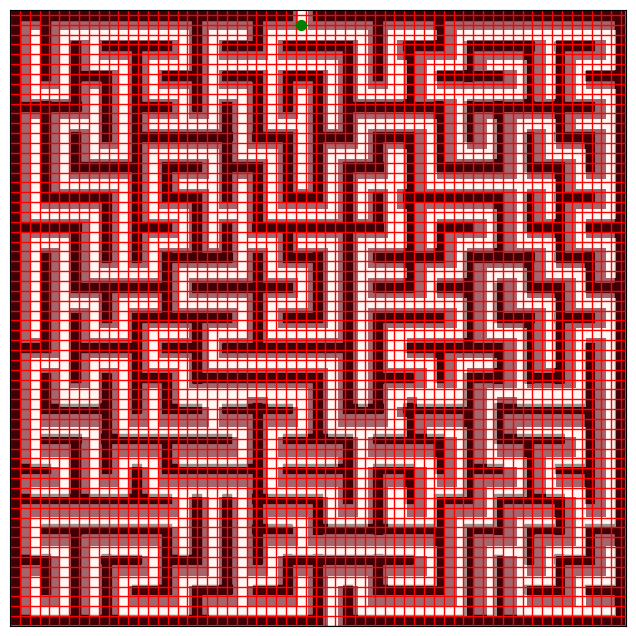

In [12]:
# Posição inicial do robô
*pcurr, _ = sim.getObjectPosition(robot_handle)
start_node = (arr_y(pcurr[1]), arr_x(pcurr[0]))
plot_graph_position(start_node)

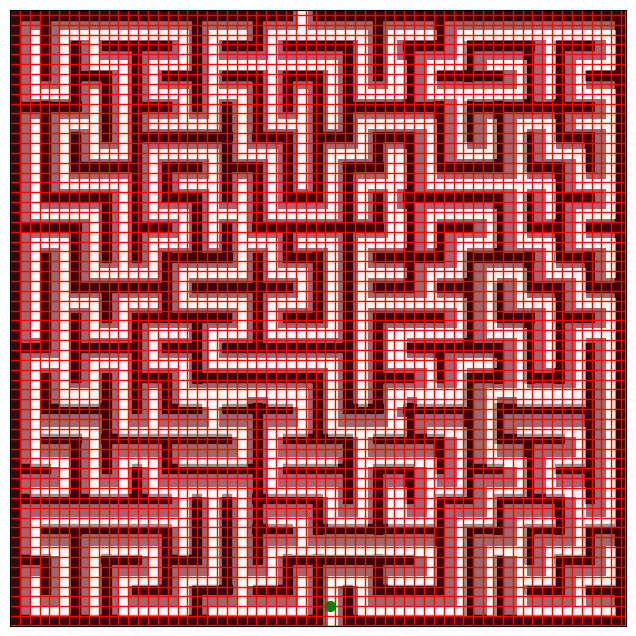

In [13]:
# Posição do alvo
*pgoal, _ = sim.getObjectPosition(goal_handle)
end_node = (arr_y(pgoal[1]), arr_x(pgoal[0]))
plot_graph_position(end_node)

Com essas informações, finalmente podemos determinar o menor caminho entre as duas células.

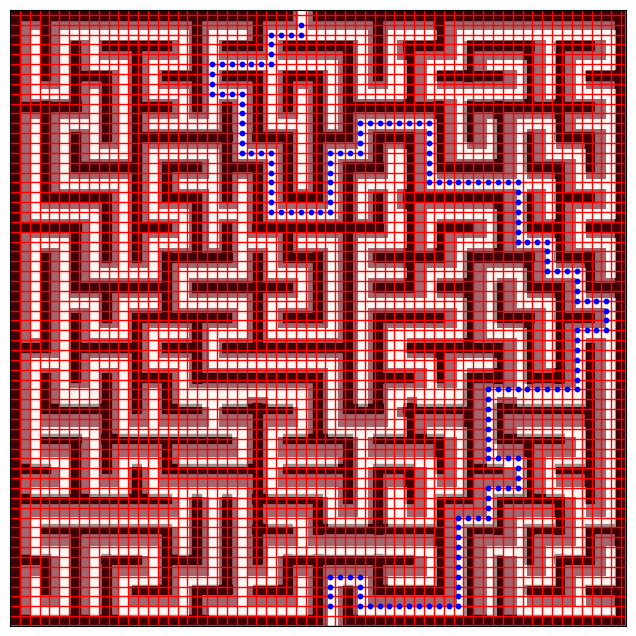

In [14]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=10, node_color='b')

Com o caminho traçado, enviamos as informações para o robô através de um controlador e realizamos o trajeto efetivamente.

In [ ]:
# Inicia a simulação
sim.startSimulation()

sim.setJointTargetVelocity(wheel[0], 0)
sim.setJointTargetVelocity(wheel[1], 0)
sim.setJointTargetVelocity(wheel[2], 0)

_, _, ocurr = sim.getObjectOrientation(robot_handle)

# Específico do robô
# Robotino
L = 0.135
r = 0.040

# Cinemática Direta
Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])

for i in range(len(path)):
    goal_node = path[i]
    pgoal = np.array([scene_x(goal_node[1]), scene_y(goal_node[0]), ocurr]) # Pose do alvo
    
    while True:
        *pcurr, _ = sim.getObjectPosition(robot_handle)
        _, _, ocurr = sim.getObjectOrientation(robot_handle)
        
        pcurr = np.array([pcurr[0], pcurr[1], ocurr]) # Pose corrente do robô
        e = pgoal - pcurr
        
        # Apenas para quebrar o loop
        if (np.linalg.norm(e[:2]) < 0.05):
            break
        
        # Controller
        qdot = gain @ (e / np.linalg.norm(e))
        
        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(pcurr[2]) @ Mdir)
        u = Minv @ qdot

        sim.setJointTargetVelocity(wheel[0], u[0])
        sim.setJointTargetVelocity(wheel[1], u[1])
        sim.setJointTargetVelocity(wheel[2], u[2])

# Termina a simulação
sim.setJointTargetVelocity(wheel[0], 0)
sim.setJointTargetVelocity(wheel[1], 0)
sim.setJointTargetVelocity(wheel[2], 0)

sim.stopSimulation()

In [69]:
# End simulation
sim.stopSimulation()